In [33]:
import warnings
warnings.filterwarnings("ignore")
from bertopic import BERTopic
from wordcloud import WordCloud
from datetime import datetime
import matplotlib.pyplot as plt
import json
from helpers import convert_filename

In [19]:
RESULTS_DIR = "findings"

In [20]:
stop_words = None
with open("stopwords.txt", "r") as stop_file:
    stop_words = set(stop_file.read().splitlines())

Start Lemmatized Tweets Processing

In [21]:
tweets = []
classes = []
candidates = []
lemm_tweets = None
timestamps = []

with open("data/lemm_tweets.json", "r") as in_file:
    lemm_tweets = json.load(in_file)

for candidate, candidate_tweets in lemm_tweets.items():
    candidates.append(candidate)
    for tweet in candidate_tweets:
        non_stop_words = []

        for word in tweet["tweet"].split():
            if word not in stop_words:
                non_stop_words.append(word)

        if len(non_stop_words) > 0:
            tweets.append(" ".join(non_stop_words))
            classes.append(candidate)
            timestamps.append(tweet["date"])

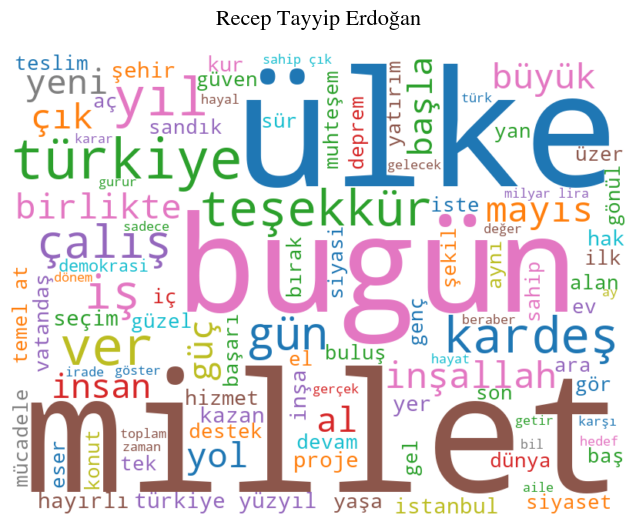

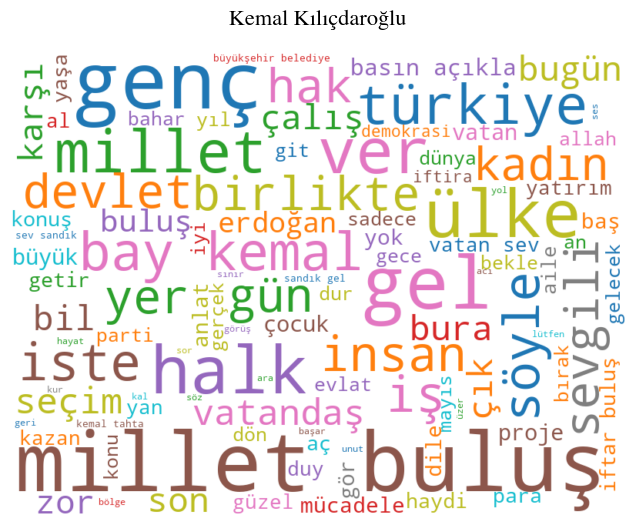

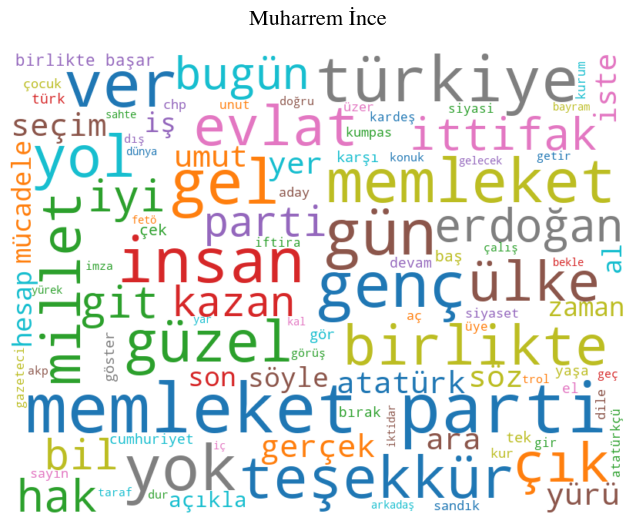

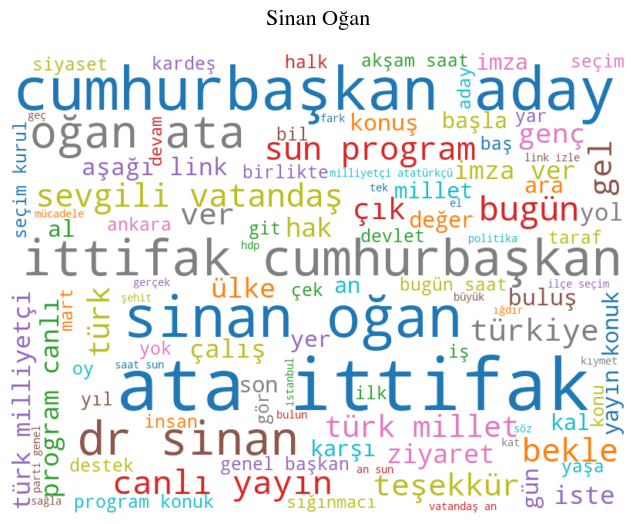

In [23]:
title_font = {"family": "Times", "size": 16}

for cand, cand_tweets in lemm_tweets.items():
    wc = WordCloud(max_words=100, random_state=42, width=800, height=600,
                   stopwords=stop_words, background_color="white", colormap="tab10", min_font_size=6)
    wc.generate(" ".join([tweet["tweet"] for tweet in cand_tweets]))

    plt.figure(figsize=(8, 6))
    plt.title(cand, fontdict=title_font, pad=20)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")

    file_name = convert_filename(cand).lower()
    wc_svg = wc.to_svg(embed_font=True)
    with open(f"{RESULTS_DIR}/wc_{file_name}.svg", "w") as out_file:
        out_file.write(wc_svg)

    plt.show()

In [24]:
topic_model = BERTopic(language="multilingual", verbose=True)
topics, probs = topic_model.fit_transform(tweets)

Batches:   0%|          | 0/68 [00:00<?, ?it/s]

2023-06-08 14:16:40,556 - BERTopic - Transformed documents to Embeddings
2023-06-08 14:16:44,111 - BERTopic - Reduced dimensionality
2023-06-08 14:16:44,147 - BERTopic - Clustered reduced embeddings


In [25]:
topic_model.reduce_topics(tweets, nr_topics=24)

topic_labels_lemm = topic_model.generate_topic_labels(
    nr_words=5, topic_prefix=False, separator=", ")

topic_model.set_topic_labels(topic_labels_lemm)
df = topic_model.get_topic_info()
df.to_excel(f"{RESULTS_DIR}/topics.xlsx", index=False)
df.head(25)

2023-06-08 14:20:50,620 - BERTopic - Reduced number of topics from 38 to 24


,Topic,Count,Name,CustomName
0,-1,709,-1_türkiye_ülke_millet_ver,"türkiye, ülke, millet, ver, türk"
1,0,188,0_cumhurbaşkan_aday_ata_ittifak,"cumhurbaşkan, aday, ata, ittifak, dr"
2,1,184,1_yayın_program_canlı_konuk,"yayın, program, canlı, konuk, sun"
3,2,171,2_millet_oy_buluş_sandık,"millet, oy, buluş, sandık, seçim"
4,3,134,3_konut_deprem_depremzede_temel,"konut, deprem, depremzede, temel, hastane"
5,4,106,4_bayram_atatürk_türk_kutlu,"bayram, atatürk, türk, kutlu, mustafa"
6,5,105,5_türk_türkiye_milliyetçi_yüzyıl,"türk, türkiye, milliyetçi, yüzyıl, millet"
7,6,82,6_şehit_rahmet_atatürk_an,"şehit, rahmet, atatürk, an, dönüm"
8,7,62,7_teşekkür_başkan_dernek_muhteşem,"teşekkür, başkan, dernek, muhteşem, misafirper..."
9,8,52,8_iyi_sanatçı_allah_iş,"iyi, sanatçı, allah, iş, çık"


In [26]:
fig = topic_model.visualize_barchart(top_n_topics=12, n_words=8, width=300)
fig.write_image(f"{RESULTS_DIR}/topic_word_scores.pdf")
fig.show()

In [27]:
topics_per_class = topic_model.topics_per_class(tweets, classes=classes)
fig = topic_model.visualize_topics_per_class(
    topics_per_class, top_n_topics=12, width=1000, custom_labels=True)
fig.write_html(f"{RESULTS_DIR}/topics_per_class.html")
fig.show()

4it [00:00, 61.67it/s]


In [28]:
for candidate in candidates:
    df = topics_per_class.query('Class == "' + candidate + '" and Topic > -1').sort_values(
        by=["Frequency"], ascending=False).loc[:, "Words":"Name"].drop("Class", axis=1).head(12)

    file_name = convert_filename(candidate).lower()
    df.to_excel(f"{RESULTS_DIR}/{file_name}.xlsx", index=False)

    print(candidate)
    print(df.to_string(index=False))
    print("\n\n")

Recep Tayyip Erdoğan
                                       Words  Frequency                                                     Name
           konut, deprem, temel, hastane, at        101                konut, deprem, depremzede, temel, hastane
           bayram, atatürk, yıl, gazi, ecdat         40                    bayram, atatürk, türk, kutlu, mustafa
            millet, sandık, seçim, oy, mayıs         35                         millet, oy, buluş, sandık, seçim
          milyar, yatırım, lira, kamu, dolar         31                       milyar, yatırım, lira, dolar, kamu
türkiye, yüzyıl, türk, milliyetçilik, millet         26                türk, türkiye, milliyetçi, yüzyıl, millet
   muhteşem, bil, şanlıurfa, geleneksel, van         26                muhteşem, bil, şanlıurfa, van, geleneksel
 teşekkür, muhteşem, istanbul, büyük, kardeş         25 teşekkür, başkan, dernek, muhteşem, misafirperverlikleri
       nükleer, santral, enerji, üretim, gaz         24                    

In [29]:
fig = topic_model.visualize_documents(
    tweets, custom_labels=True, topics=list(range(12)))
fig.write_html(f"{RESULTS_DIR}/doc_visualization.html")
fig.show()

In [48]:
dates = [datetime.fromtimestamp(ts).strftime("%Y-%m-%d %H:%M:%S") for ts in timestamps]
topics_over_time = topic_model.topics_over_time(tweets, dates, nr_bins=50, datetime_format="%Y-%m-%d %H:%M:%S")
fig = topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=12, height=600)
fig.write_html(f"{RESULTS_DIR}/topics_over_time.html")
fig.show()

50it [00:00, 89.12it/s]
